<a href="https://colab.research.google.com/github/anubhavnehru/Introduction-to-Deep-Learning/blob/main/MIS285N_HW3_an_mb_sk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MIS 285N Homework 3
**Due: Thursday, February 15, 11:59 pm**

#### MILIND BHATIA (mb67324)
#### ANUBHAV NEHRU (an33868)
#### SIMRAN KAUR (sk57859)

Notebook Link - https://colab.research.google.com/drive/1GQBnLx83XOku1542maCWH74H17LT4yVN?usp=sharing&authuser=1


Submit:

A pdf of your notebook with solutions.
A link to your colab notebook or also upload your .ipynb if not working on colab.

# Goals of this Homework: Fine Tuning and Transfer Learning

The goal of this colab notebook and homework is to get down the basics of Transfer learning, and harnessing the power of pre-trained notebooks. Along the way, we get experience with creating and labeling data sets, and a number of other Python tools.

Specifically, we do the following:

* In this colab notebook, we create our own labeled image data set, with calls to the Bing API. We use this to download images with user-specified labels, into train and test directories.

* We preprocess all the images and use the directory names as lables to create our training and testing data sets.

* Then we download a pre-trained convolutional neural network from Pytorch. There is wide selection here. These have been trained on ImageNet. See references below.

* Then we add a new last layer, and train. Note that the last layer we add has to have the right size, namely, the number of classes in our data.

* Things to play with: Choosing different pre-trained models; Fine tuning the entire network vs freezing and fine tuning only the last layer or layers; Possibly adding more of our own layers at the end. (See the last optional problem at the end).


Some references:

The bing image downloader package from here https://pypi.org/project/bing-image-downloader/


# The following will allow us to call the Bing Image Downloader

In [2]:
!pip install bing-image-downloader


In [3]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
import requests
from bing_image_downloader import downloader
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

plt.ion()   # interactive mode


# Downloading the images we need

In [4]:
# These are the functions we need for asking for query terms, number of images
# and the fraction of train/test split
def get_query_terms():
    """Ask the user for a list of query terms."""
    queries = input("Enter query terms separated by commas: ").split(',')
    return [query.strip() for query in queries]


def get_positive_integers():
    """Ask the user for a list of positive integers."""
    while True:
        numbers = input("Enter positive integers corresponding to each query, separated by commas: ").split(',')
        try:
            # Convert string inputs to integers
            numbers = [int(num.strip()) for num in numbers]

            # Check if all numbers are positive
            if all(num > 0 for num in numbers):
                return numbers
            else:
                print("All numbers must be positive. Please try again.")
        except ValueError:
            print("Invalid input. Please enter integers only.")


def get_train_test_proportion():
    """Ask the user for a number between 0 and 1 and ensure it is in that range."""
    while True:
        try:
            # Ask the user for a number and try to convert it to a float
            num = float(input("What fraction of the data should be training? For example, enter 0.75 for 75 percent: "))

            # Check if the number is between 0 and 1 (inclusive)
            if 0 <= num <= 1:
                return num
            else:
                print("The number must be between 0 and 1. Please try again.")
        except ValueError:
            print("Invalid input. Please enter a valid number between 0 and 1.")

# Problem 0

Run the above code, to make your own data set. Choose terms that aren't already one of the 1000 classes in the Imagenet dataset.

I recommend starting small: 2 or 3 different terms, and maybe 100-200 images max from each.

In [6]:
# Now we get the queries
queries = get_query_terms()
# And the number of each
numbers = get_positive_integers()
# And the fraction of training data
frac_train = get_train_test_proportion()
# Check if number of queries matches number of positive integers
if len(queries) != len(numbers):
  print("Number of queries and integers do not match!")

for query, n in zip(queries, numbers):
  n_tr = int(math.floor(n*frac_train))
  downloader.download(query, limit=n_tr, output_dir='dataset/train', adult_filter_off=True, force_replace=False,timeout=60, verbose=False)
  n_test = int(math.floor(n * (1-frac_train)))
  downloader.download(query, limit=n_test, output_dir='dataset/test', adult_filter_off=True, force_replace=False, timeout=60, verbose=False)


Enter query terms separated by commas: iphone, taj mahal, ferrari
Enter positive integers corresponding to each query, separated by commas: 200,200,200
What fraction of the data should be training? For example, enter 0.75 for 75 percent: 0.75
[%] Downloading Images to /content/dataset/train/iphone
[Error]Invalid image, not saving https://img.android.com.pl/images/user-images/2018/02/trio-iphones-ios.jpg

[!] Issue getting: https://img.android.com.pl/images/user-images/2018/02/trio-iphones-ios.jpg
[!] Error:: Invalid image, not saving https://img.android.com.pl/images/user-images/2018/02/trio-iphones-ios.jpg

[!] Issue getting: https://www.proshop.dk/Images/915x900/2295074_72893048818f.jpg
[!] Error:: HTTP Error 403: Forbidden
[!] Issue getting: https://currys-ssl.cdn.dixons.com/inspiration/content-media/iphone x(1).jpg
[!] Error:: URL can't contain control characters. '/inspiration/content-media/iphone x(1).jpg' (found at least ' ')
[!] Issue getting: http://gamer-tech.co.uk/img/cms/Yo

# Let's make sure we downloaded enough of each

In [7]:
import os

def count_files_in_directory(directory, prefix=""):
    """
    Recursively counts the number of files in each directory and subdirectory.

    Args:
    - directory: The directory path to start counting from.
    - prefix: A string used for indentation to visualize the folder structure.
    """
    num_files = sum([len(files) for r, d, files in os.walk(directory)])
    print(f"{prefix}{os.path.basename(directory)}: {num_files} files")

    for subdir in next(os.walk(directory))[1]:  # List subdirectories of the current directory
        path = os.path.join(directory, subdir)  # Full path of the subdirectory
        count_files_in_directory(path, prefix + "  ")  # Recursively count in this subdirectory

# Path to the dataset directory
dataset_dir = './dataset'

# Start the recursive count
count_files_in_directory(dataset_dir)


dataset: 608 files
  test: 150 files
    taj mahal: 50 files
    iphone: 50 files
    ferrari: 50 files
  train: 458 files
    taj mahal: 150 files
    iphone: 150 files
    ferrari: 150 files


# Preprocessing the data

Now that we've downloaded the data we want, we do some basic preprocessing with functions from Torchvision.

For the training data, we normalize and also use some data augmentation.

For the validation set, we just normalize.

# Problem 1 (Nothing to turn in)
Read about this here: https://pytorch.org/vision/stable/transforms.html

# We made dataloaders out of our training and testing data

In [8]:

# Data augmentation and normalization for training
# Just normalization for validation

# The directory that contains the data
data_dir = 'dataset'

# Now we apply the usual transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Problem 2
Write code that calls the dataloaders and displays some number of images, with their true labels.

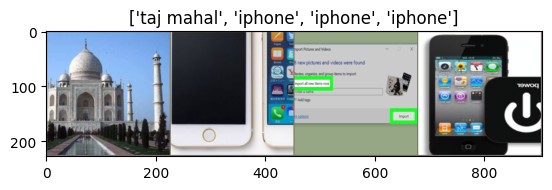

In [9]:
# Function to display images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


# Download a pre-trained model

We will now download a pretrained model that has been trained on Imagenet. I recomend starting with Resnet18. See here for other larger or smaller pre-trained modfels https://pytorch.org/vision/stable/models.html

In [11]:
# Now we load a pre-trained model, and replace the last layer with a non-initialized linear layer.
# Now we load a pre-trained model, and replace the last layer with a non-initialized linear layer.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# This command loads a pre-trained model
model_ft = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)

# Move the model to the appropriate device
model_ft = model_ft.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 81.7MB/s]


# Problem 3

Redefine the last layer of your neural network (called model_ft) to be a linear (fully connected layer) whose input size is whatever the input size is of the the current last layer, and whose output size is the number of labels your new data set has.

You need to figure out how to do this. It's not too difficult. You need will use similar commands as you used in the last 2 homeworks in order to define a linear layer. The key will be to find out what the last layer is called, and also to find out what is its input size, so that you can properly define the size of the last fully connected (linear) layer.

In [12]:
from torchsummary import summary

# Assuming model_ft is your model
summary(model_ft, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [13]:
for name, layer in model_ft.named_modules():
    print(name,layer)

 ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [14]:
# Number of classes in your dataset
num_classes = len(class_names)

# Get the number of input features for the last layer
num_ftrs = model_ft.fc.in_features

# Redefine the last fully connected layer
model_ft.fc = nn.Linear(num_ftrs, num_classes)

# Transfer the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ft = model_ft.to(device)


# Training

* We are going to fine-tune by training all the layers.

* We can also freeze the old layers, and only update the last layers that we added. (This is not implemented below.)

In [15]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step() # updates the learning rate

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best test Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Parameters of the optimization

# Problem 4 (Optional)
Explore choosing different learning rates or optimizers to see how things go.

In [16]:
# We need to set the loss function, the optimizer, and the learning rate scheduler
criterion = nn.CrossEntropyLoss()
# though we're fine tuning, we're updating all parameters
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# the scheduler decreases the learning rate by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Train

In [17]:
# Now we train
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.5091 Acc: 0.7969
test Loss: 0.0163 Acc: 1.0000

Epoch 1/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.2785 Acc: 0.8996
test Loss: 0.0089 Acc: 1.0000

Epoch 2/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.2654 Acc: 0.8973
test Loss: 0.0230 Acc: 0.9933

Epoch 3/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.2104 Acc: 0.9241
test Loss: 0.0113 Acc: 0.9933

Epoch 4/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.3747 Acc: 0.8951
test Loss: 0.0029 Acc: 1.0000

Epoch 5/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.2914 Acc: 0.9040
test Loss: 0.0035 Acc: 1.0000

Epoch 6/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.2217 Acc: 0.9308
test Loss: 0.0020 Acc: 1.0000

Epoch 7/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.1782 Acc: 0.9487
test Loss: 0.0011 Acc: 1.0000

Epoch 8/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.1493 Acc: 0.9531
test Loss: 0.0006 Acc: 1.0000

Epoch 9/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.1587 Acc: 0.9598
test Loss: 0.0013 Acc: 1.0000

Epoch 10/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.1585 Acc: 0.9621
test Loss: 0.0021 Acc: 1.0000

Epoch 11/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.1621 Acc: 0.9487
test Loss: 0.0005 Acc: 1.0000

Epoch 12/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.1252 Acc: 0.9598
test Loss: 0.0007 Acc: 1.0000

Epoch 13/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.1329 Acc: 0.9554
test Loss: 0.0012 Acc: 1.0000

Epoch 14/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.1337 Acc: 0.9554
test Loss: 0.0006 Acc: 1.0000

Epoch 15/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.1494 Acc: 0.9576
test Loss: 0.0006 Acc: 1.0000

Epoch 16/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.1351 Acc: 0.9621
test Loss: 0.0007 Acc: 1.0000

Epoch 17/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.1757 Acc: 0.9487
test Loss: 0.0004 Acc: 1.0000

Epoch 18/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0758 Acc: 0.9710
test Loss: 0.0007 Acc: 1.0000

Epoch 19/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.1560 Acc: 0.9531
test Loss: 0.0006 Acc: 1.0000

Epoch 20/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.1705 Acc: 0.9397
test Loss: 0.0007 Acc: 1.0000

Epoch 21/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0618 Acc: 0.9844
test Loss: 0.0004 Acc: 1.0000

Epoch 22/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.1735 Acc: 0.9509
test Loss: 0.0006 Acc: 1.0000

Epoch 23/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.0542 Acc: 0.9866
test Loss: 0.0009 Acc: 1.0000

Epoch 24/24
----------


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 0.1969 Acc: 0.9442
test Loss: 0.0005 Acc: 1.0000

Training complete in 10m 1s
Best test Acc: 1.000000


# Problem 5

Report your accuracy on the testing set. You should compute this explicitly by running all your testing examples through the model and checking them against their true labels.

In [18]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = model_ft(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the validation dataset: {100 * correct / total} %')

Accuracy of the network on the validation dataset: 100.0 %


# Now let's visualize to see how well we did

# Problem 6

Print out images from the test set, reporting the predicted labels and the true labels.

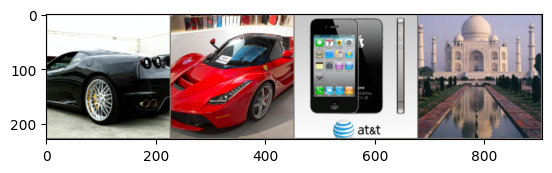

GroundTruth:  ferrari ferrari iphone taj mahal
Predicted:  ferrari ferrari iphone taj mahal


In [19]:
# Let's see how well this trained model performs on a couple data points.
dataiter = iter(dataloaders['test'])
images, labels = next(dataiter)

# Print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % class_names[labels[j]] for j in range(4)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images, labels = images.to(device), labels.to(device)

# Forward pass to get predictions
outputs = model_ft(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]] for j in range(4)))


# Problem 7 (Optional)

Experiment with some/all of the following:

* Play with different pre-trained models
* Experiment with different pre-processing of the data (e.g., turn data augmentation on or off).
* Experiment with adding more/fewer layers, and/or layers of different size.
* Fine tune by training everything or only the last (new) layer -- this requires figuring out how to only update some of the layers.
* Try to reduce the number of images you use for training. How few can you use and still get good accuracy? Remember that you were all able to learn what a Goblin shark is with only one single example.